<a href="https://colab.research.google.com/github/YuichH/ML/blob/main/Kaggle/Tabular_Playground_Series_Jun_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#共通

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


In [ ]:
import os

# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
import seaborn as sns

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import logging
import time
import warnings

import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)

warnings.filterwarnings("ignore")

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=100)
parser.add_argument("--batch_size", type=int, default=128)
# parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--work_dir", default="/content/drive/MyDrive/Kaggle/Tabular Playground Series - Jun 2021/")
parser.add_argument("--zip_file", default="tabular-playground-series-jun-2021.zip")
parser.add_argument("--input_dir", default="/content/")
parser.add_argument("--model_dir", default="/content/drive/MyDrive/Kaggle/Tabular Playground Series - Jun 2021/")
parser.add_argument("--model_name", default="Tabular Playground Series - Jun 2021")
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=100, batch_size=128, work_dir='/content/drive/MyDrive/Kaggle/Tabular Playground Series - Jun 2021/', zip_file='tabular-playground-series-jun-2021.zip', input_dir='/content/', model_dir='/content/drive/MyDrive/Kaggle/Tabular Playground Series - Jun 2021/', model_name='Tabular Playground Series - Jun 2021')


In [ ]:
!pip install kaggle

In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!mkdir -p ~/.kaggle/
!cp -p /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
targetFileName = opt.work_dir + opt.zip_file
if os.path.exists(targetFileName):
    print("file exists")
else:
    !kaggle competitions download -c tabular-playground-series-jun-2021
    !cp -p /content/*.zip "/content/drive/MyDrive/Kaggle/Tabular Playground Series - Jun 2021/"

file exists


In [ ]:
!cp -p "/content/drive/MyDrive/Kaggle/Tabular Playground Series - Jun 2021/tabular-playground-series-jun-2021.zip" /content/

In [ ]:
!unzip /content/tabular-playground-series-jun-2021.zip

Archive:  /content/tabular-playground-series-jun-2021.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#データ読み込み

In [ ]:
train = pd.read_csv(opt.input_dir + "train.csv")
train.columns

Index(['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',
   

In [ ]:
train.head(5)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2


In [ ]:
test = pd.read_csv(opt.input_dir + "test.csv")
test.columns

Index(['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',
   

In [ ]:
test.head(5)

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,200000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200001,1,2,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
2,200002,0,1,7,1,0,0,0,0,6,...,3,0,0,0,0,3,0,2,0,0
3,200003,0,0,0,4,3,1,0,0,0,...,0,0,0,1,0,0,0,4,0,0
4,200004,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
sample = pd.read_csv(opt.input_dir + "sample_submission.csv")
sample.head(5)

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
1,200001,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
2,200002,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
3,200003,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
4,200004,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111


In [ ]:
print("Training Size:" + str(train.shape))
print("test Size:" + str(test.shape))
print("sample Size:" + str(sample.shape))

Training Size:(200000, 77)
test Size:(100000, 76)
sample Size:(100000, 10)


#前処理
LightGBMは、数値に変換したカテゴリー変数をcategorical_featuresに設定すると、カテゴリー値（大小に意味がない値）として扱うことができます。

XGBoostは、そのような設定がないので、更にOne-Hotエンコーディングやダミーエンコーディングを行う必要があります。

<Axes: xlabel='target', ylabel='count'>

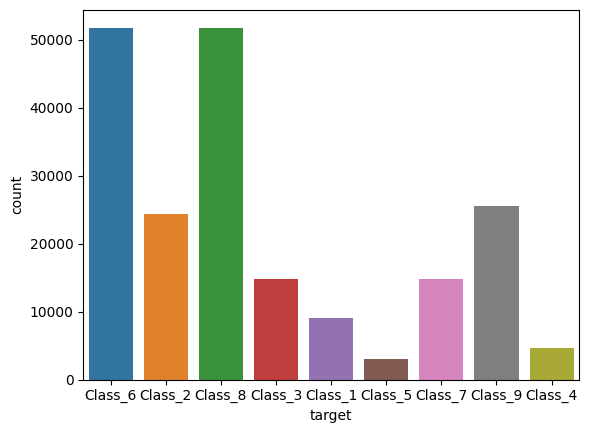

In [ ]:
#目的変数
sns.countplot(x="target", data=train)

In [ ]:
print(train[['id', 'target']].groupby('target').count())

            id
target        
Class_1   9118
Class_2  24431
Class_3  14798
Class_4   4704
Class_5   3064
Class_6  51811
Class_7  14769
Class_8  51763
Class_9  25542


In [ ]:
#Save the 'Id' column
train_ID = train['id']
test_ID = test['id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

print("Training Size:" + str(train.shape))
print("test Size:" + str(test.shape))

Training Size:(200000, 76)
test Size:(100000, 75)


In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl.fit(list(train['target'].values))
train['target'] = lbl.transform(list(train['target'].values))

In [ ]:
#同時編集
num_train = train.shape[0]
num_test = test.shape[0]
# y_train = train['target']
all_data = pd.concat((train, test)).reset_index(drop=True)
# all_data.drop(['target'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (300000, 76)


In [ ]:
#データフレームの各列について欠損値の割合
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100

#割合が0の列を取り除き、欠損値の割合が多い順にソートし、先頭から30件まで
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

#欠損値の割合を表すデータフレームを作成
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
target,33.333333


<Axes: >

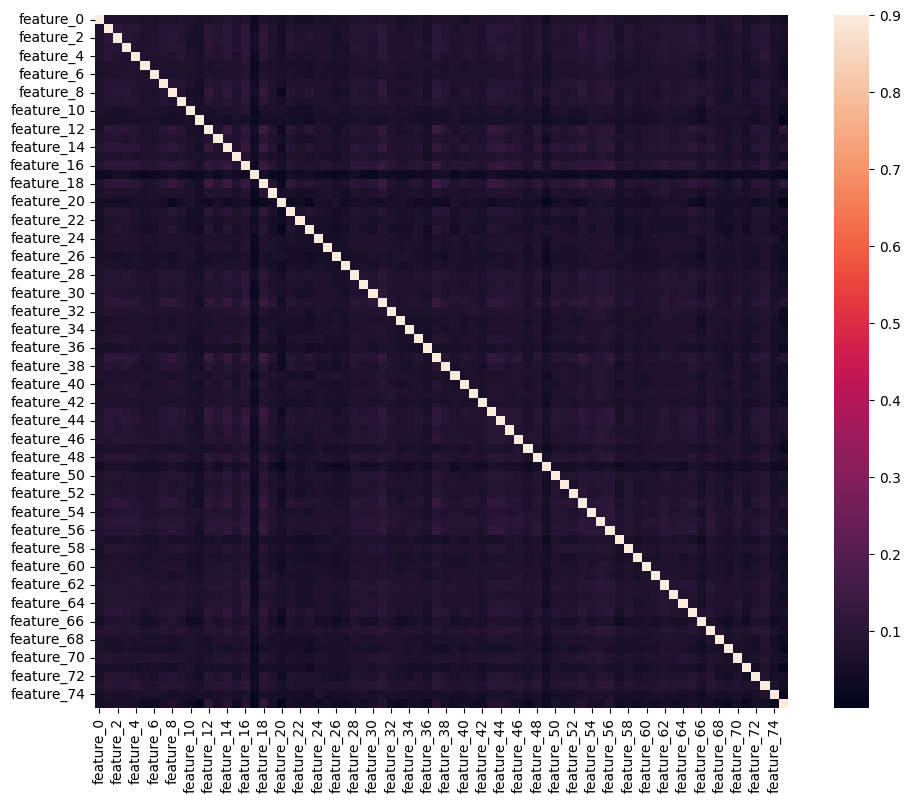

In [ ]:
#相関
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
train = all_data[:num_train]
test = all_data[num_train:]
test.drop(['target'], axis=1, inplace=True)

array([[<Axes: title={'center': 'feature_0'}>,
        <Axes: title={'center': 'feature_1'}>,
        <Axes: title={'center': 'feature_2'}>,
        <Axes: title={'center': 'feature_3'}>,
        <Axes: title={'center': 'feature_4'}>,
        <Axes: title={'center': 'feature_5'}>,
        <Axes: title={'center': 'feature_6'}>,
        <Axes: title={'center': 'feature_7'}>,
        <Axes: title={'center': 'feature_8'}>],
       [<Axes: title={'center': 'feature_9'}>,
        <Axes: title={'center': 'feature_10'}>,
        <Axes: title={'center': 'feature_11'}>,
        <Axes: title={'center': 'feature_12'}>,
        <Axes: title={'center': 'feature_13'}>,
        <Axes: title={'center': 'feature_14'}>,
        <Axes: title={'center': 'feature_15'}>,
        <Axes: title={'center': 'feature_16'}>,
        <Axes: title={'center': 'feature_17'}>],
       [<Axes: title={'center': 'feature_18'}>,
        <Axes: title={'center': 'feature_19'}>,
        <Axes: title={'center': 'feature_20'}>,


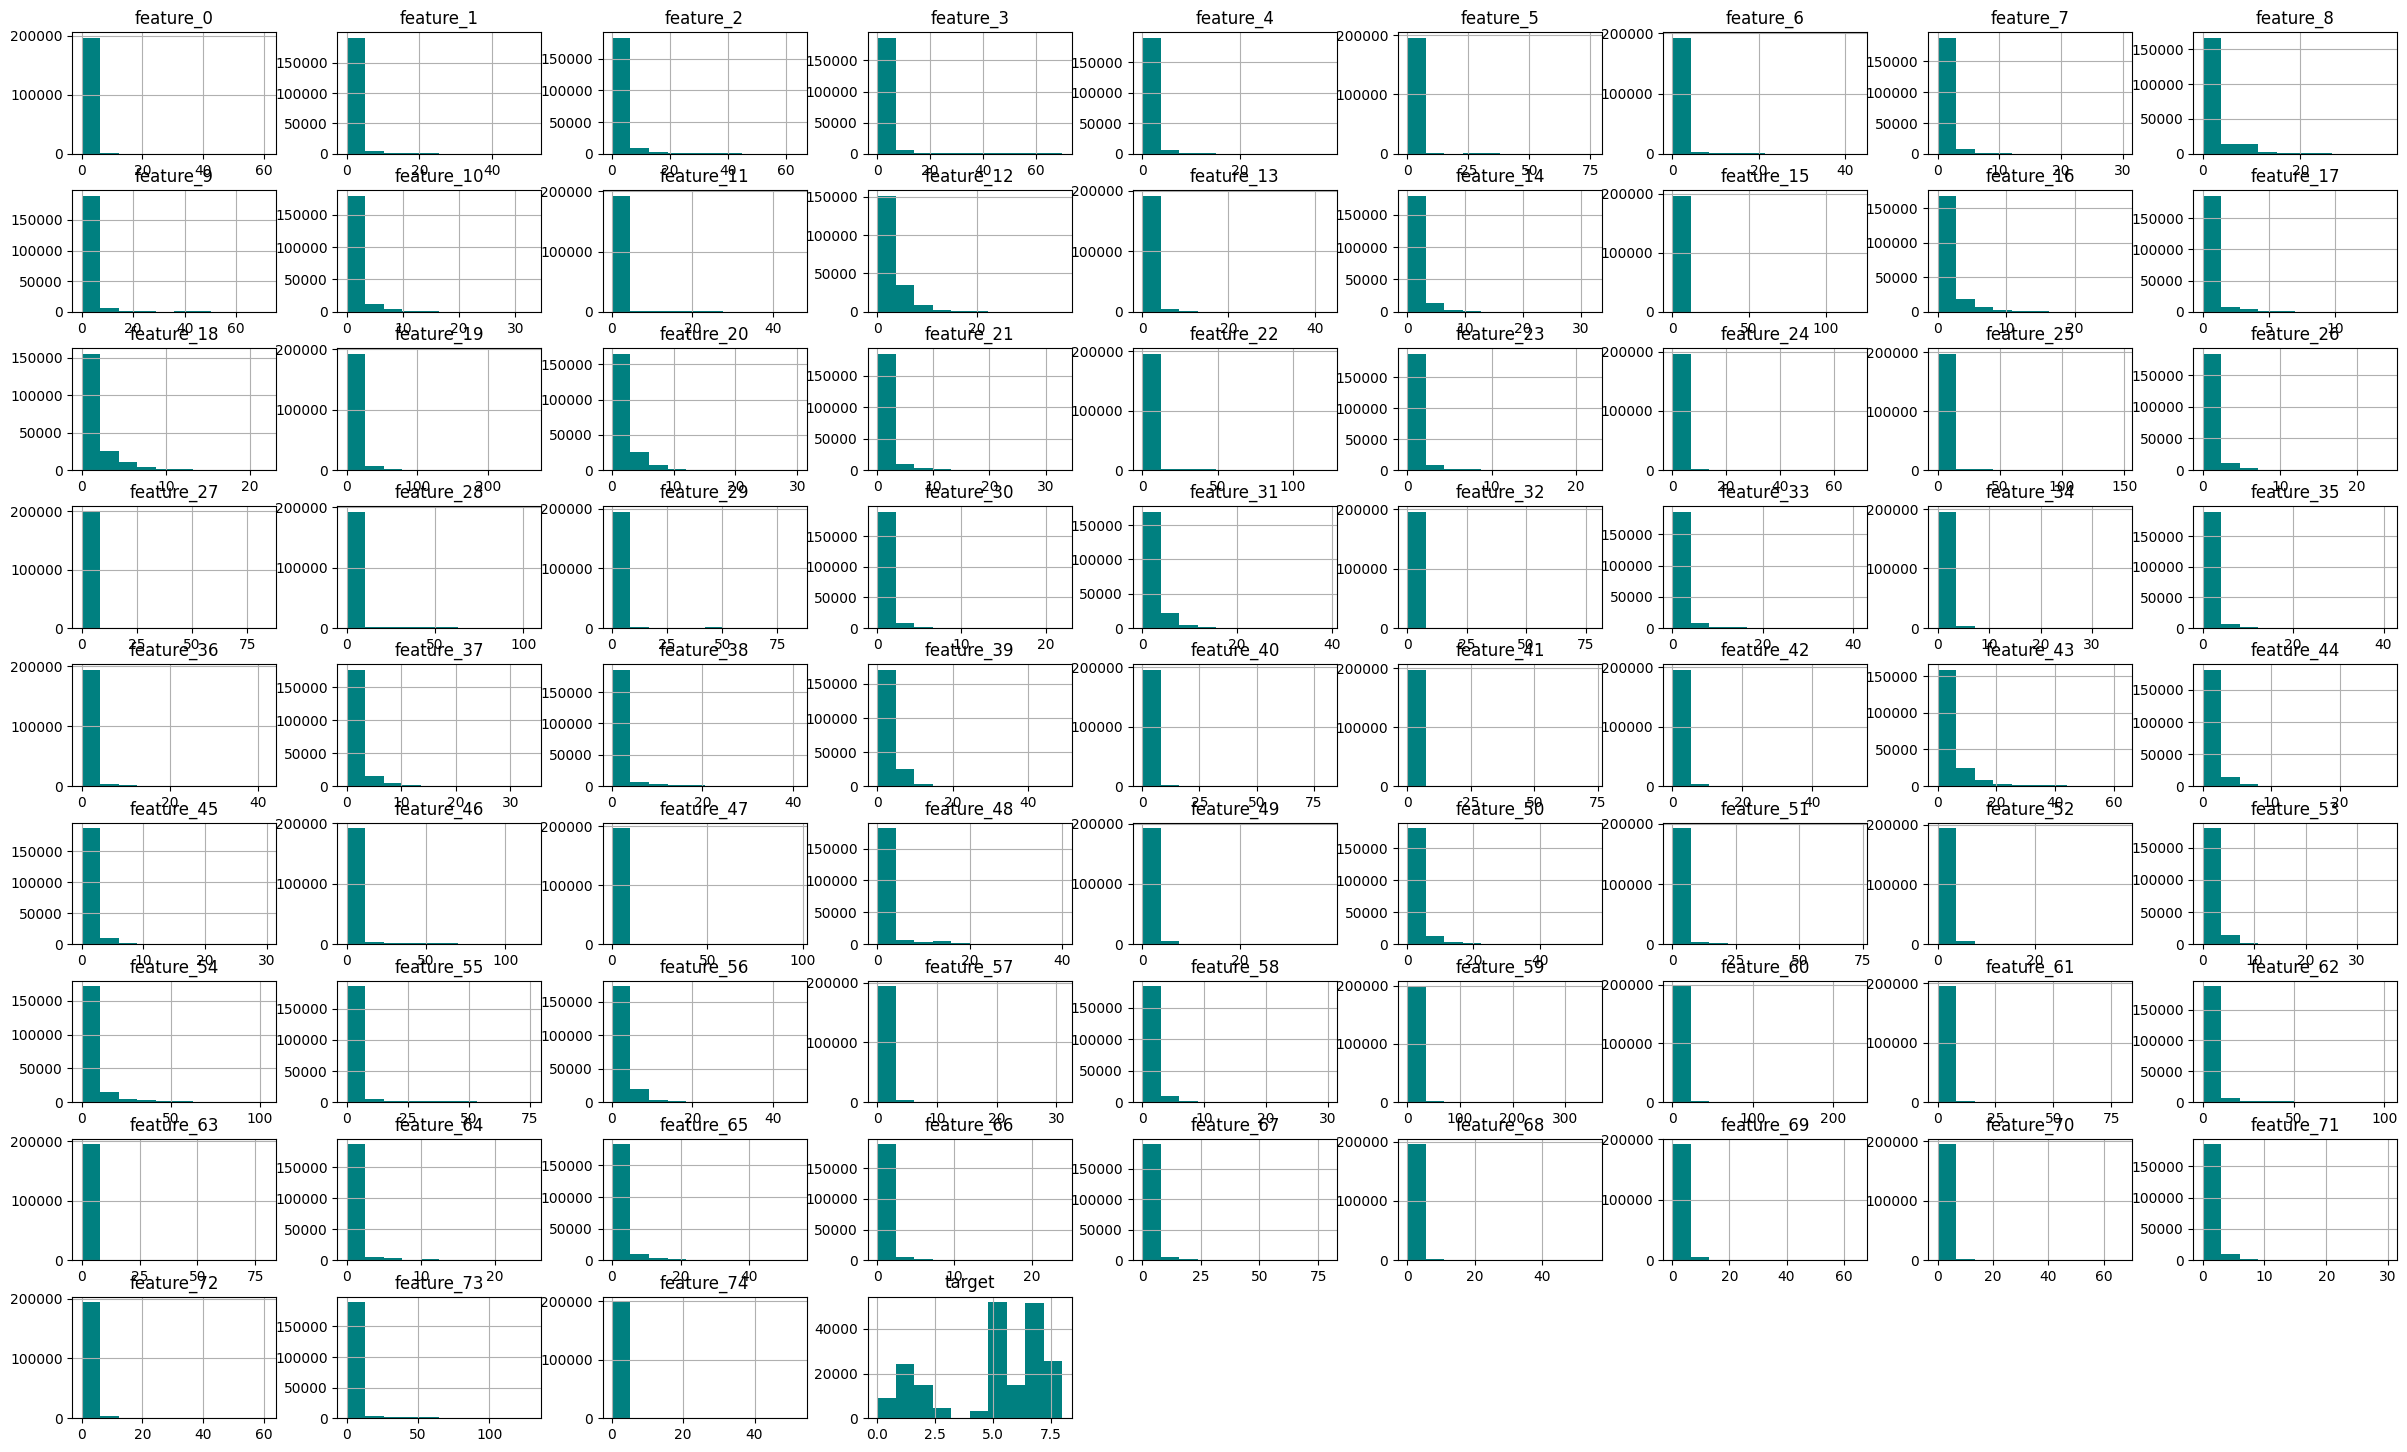

In [ ]:
train.hist(bins=10, figsize=(30,18), color = 'teal')

#モデリング

In [ ]:
# from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss, roc_auc_score
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#モデル学習のための、訓練データとテストデータを7:3で分割
target_df = train['target']
train_df = train.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, test_size=0.3, shuffle=True, random_state=42, stratify=target_df)

In [ ]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test, y_test)

In [ ]:
params = {'objective': 'multiclass'      # 目的関数：多値分類、マルチクラス分類
        #   ,'boosting_type': 'gbdt'        # 勾配ブースティング
          ,'metric': 'multi_logloss'      # 分類モデルの性能を測る指標
          ,'num_class': 9                 # 目的変数のクラス数
          ,'learning_rate': 0.05          # 学習率（初期値0.1）
          ,'num_leaves': 5                # 決定木の複雑度を調整（初期値31）
          ,'min_data_in_leaf': 6          # データの最小数（初期値20）
        #   ,'n_estimators': 720              # 木の数
        #   ,'max_bin': 55                    # 一つの分岐に入るデータ数の最大値を指定
        #   ,'bagging_fraction': 0.8
        #   ,'bagging_freq': 5
        #   ,'bagging_seed': 9
        #   ,'feature_fraction': 0.2319       # 学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する
        #   ,'feature_fraction_seed': 9
        #   ,'min_data_in_leaf': 6            # 大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
        #   ,'min_sum_hessian_in_leaf': 11
         }
model = lgb.train(params,dtrain)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3282
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 75
[LightGBM] [Info] Start training from score -3.088161
[LightGBM] [Info] Start training from score -2.102447
[LightGBM] [Info] Start training from score -2.603787
[LightGBM] [Info] Start training from score -3.749843
[LightGBM] [Info] Start training from score -4.178503
[LightGBM] [Info] Start training from score -1.350707
[LightGBM] [Info] Start training from score -2.605816
[LightGBM] [Info] Start training from score -1.351645
[LightGBM] [Info] Start training from score -2.058016


In [ ]:
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob,axis = 1)
print(pred)

[7 7 7 ... 7 5 5]


In [ ]:
acc = accuracy_score(y_test,pred)
print('Acc :', acc)

Acc : 0.36035


In [ ]:
print(y_test)

150168    7.0
50217     5.0
114330    4.0
133959    3.0
54520     6.0
         ... 
96031     5.0
83383     5.0
100968    8.0
87987     5.0
42278     0.0
Name: target, Length: 60000, dtype: float64


In [ ]:
pred_prob

array([[0.04632801, 0.06016642, 0.04730531, ..., 0.0969579 , 0.45896222,
        0.12261134],
       [0.03514871, 0.05719364, 0.03696445, ..., 0.08710031, 0.32796066,
        0.09151996],
       [0.05053442, 0.0703701 , 0.05318434, ..., 0.09702348, 0.36862828,
        0.15367893],
       ...,
       [0.03830841, 0.08202113, 0.06750081, ..., 0.09264945, 0.3914539 ,
        0.1335065 ],
       [0.0542747 , 0.1823724 , 0.12038734, ..., 0.0463754 , 0.15865476,
        0.17035422],
       [0.02577444, 0.02491299, 0.0210899 , ..., 0.05204481, 0.21879303,
        0.05737963]])

In [ ]:
logloss = log_loss(y_test, pred_prob)
print('log_loss :', logloss)

log_loss : 1.7565192582224285


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

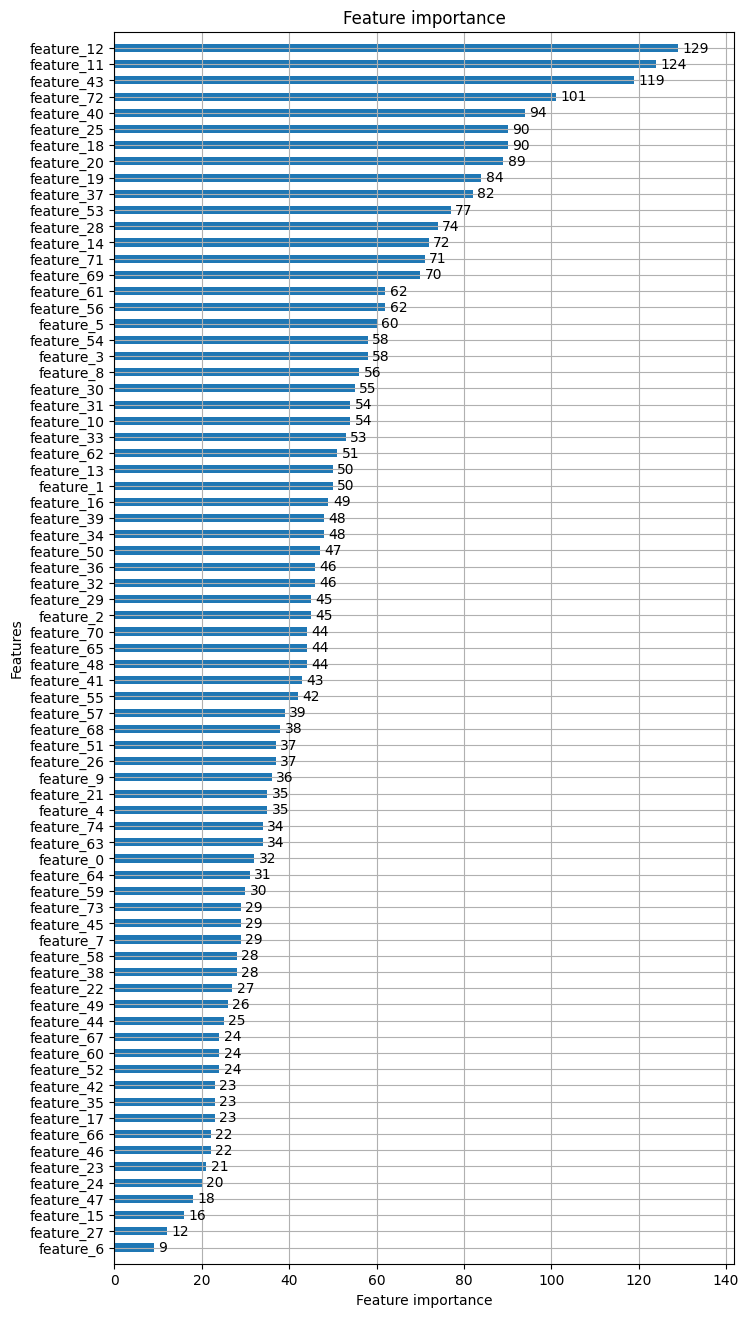

In [ ]:
# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

#提出データ作成

In [ ]:
pred_test = model.predict(test)

In [ ]:
pred_test

array([[0.04460222, 0.35246843, 0.14973025, ..., 0.02971572, 0.07216446,
        0.12544941],
       [0.04520963, 0.10015218, 0.0772547 , ..., 0.08151334, 0.2724351 ,
        0.12919314],
       [0.03678008, 0.0437931 , 0.03221891, ..., 0.03971847, 0.16588407,
        0.08294669],
       ...,
       [0.06234394, 0.23171484, 0.12413125, ..., 0.0521484 , 0.15126162,
        0.15592034],
       [0.03098163, 0.03174419, 0.02650178, ..., 0.06774493, 0.31677866,
        0.08337995],
       [0.04361302, 0.0882552 , 0.06502157, ..., 0.08664905, 0.21555059,
        0.13515699]])

In [ ]:
len(pred_test)

100000

In [ ]:
len(test_ID)

100000

In [ ]:
submission = pd.DataFrame({
    'id': test_ID,
    'Class_1': pred_test[:, 0],
    'Class_2': pred_test[:, 1],
    'Class_3': pred_test[:, 2],
    'Class_4': pred_test[:, 3],
    'Class_5': pred_test[:, 4],
    'Class_6': pred_test[:, 5],
    'Class_7': pred_test[:, 6],
    'Class_8': pred_test[:, 7],
    'Class_9': pred_test[:, 8]
})
submission.to_csv('submission.csv', index=False)

#提出

In [ ]:
!kaggle competitions submit tabular-playground-series-jun-2021 -f /content/submission.csv -m "api submission"

100% 17.9M/17.9M [00:02<00:00, 7.07MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021

In [ ]:
!kaggle competitions submissions -c tabular-playground-series-jun-2021

fileName               date                 description     status    publicScore  privateScore  
---------------------  -------------------  --------------  --------  -----------  ------------  
submission.csv         2023-07-01 00:01:04  api submission  complete  1.76093      1.75559       
sample_submission.csv  2023-06-18 00:42:38  api submission  complete  2.19722      2.19722       
